In [1]:
# import important stuff
import numpy as np
import pandas as pd

In [2]:
# import visulization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [3]:
# import sklearn modules
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [4]:
# import the data from csv file with a series of NAN values 
df= pd.read_csv('Consumer_Complaints_sample.csv' )

In [5]:
# Overlook of the data set
df.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,358563,03/20/2015,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,PNC Bank N.A.,AL,35080,Older American,Consent not provided,Web,03/20/2015,Closed with explanation,Yes,Yes,1292440
1,559788,02/18/2014,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,PNC Bank N.A.,NJ,07719,NaN,NaN,Web,02/26/2014,Closed with explanation,Yes,No,718324
2,290729,09/09/2016,Consumer Loan,Installment loan,Taking out the loan or lease,NaN,I had my credit score ran 2 times by Spring Le...,NaN,"ONEMAIN FINANCIAL HOLDINGS, LLC.",TN,378XX,NaN,Consent provided,Web,09/13/2016,Closed with explanation,Yes,No,2102639
3,382875,04/23/2016,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,NaN,Company believes it acted appropriately as aut...,ERC,TN,38478,NaN,Consent not provided,Web,04/27/2016,Closed with non-monetary relief,Yes,Yes,1891827
4,656826,08/04/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,GA,30041,NaN,Consent not provided,Web,08/04/2016,Closed with non-monetary relief,Yes,No,2044411


In [6]:
# drop the rows where 'consumer disputed?' is missing
df.dropna(axis=0, subset=['Consumer disputed?'], inplace=True)

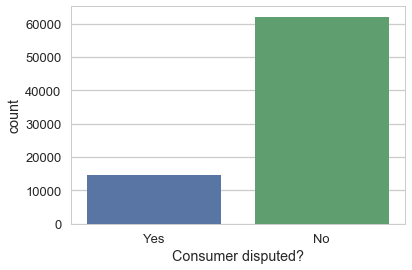

In [7]:
#check how many complaints were disputed. 
sns.countplot(df['Consumer disputed?'])

In [8]:
top_issue = list(pd.DataFrame(df['Issue'].value_counts()[0:30]).index)

df_top_issue = df[df['Issue'].isin(top_issue)]

In [9]:
df_top_issue['Issue'].value_counts().head(5)

Loan modification,collection,foreclosure    11305
Incorrect information on credit report      10198
Loan servicing, payments, escrow account     7744
Cont'd attempts collect debt not owed        6169
Account opening, closing, or management      3756
Name: Issue, dtype: int64

In [10]:
top_company = list(pd.DataFrame(df_top_issue.Company.value_counts()[0:30]).index)
df_top_issue_comp = df_top_issue[df_top_issue['Company'].isin(top_company)]

In [11]:
df_top_issue_comp['Company'].value_counts().head(5)

BANK OF AMERICA, NATIONAL ASSOCIATION     6165
WELLS FARGO & COMPANY                     4891
EQUIFAX, INC.                             4786
Experian Information Solutions Inc.       4534
TRANSUNION INTERMEDIATE HOLDINGS, INC.    3984
Name: Company, dtype: int64

In [12]:
# choose categoric columns that we are using for initial test
categoric = df_top_issue_comp[['Product','Issue', 'Company', 'Consumer consent provided?', 'Submitted via', 'Timely response?', 'Company response to consumer']]
target_d = df_top_issue_comp['Consumer disputed?']

In [13]:
df_dummy_cate = pd.get_dummies(data=categoric, drop_first=True)
target_dummy = pd.get_dummies(data=target_d, drop_first=True)
df_dummy = df_dummy_cate.join(target_dummy)

In [14]:
#df_dummy.corr()['Yes']

Consumer disputed?     Company response to consumer        No       Yes
0                                            Closed  0.761750  0.238250
1                           Closed with explanation  0.786985  0.213015
2                       Closed with monetary relief  0.900439  0.099561
3                   Closed with non-monetary relief  0.879846  0.120154
4                                Closed with relief  0.846847  0.153153
5                             Closed without relief  0.728789  0.271211
6                                 Untimely response  1.000000       NaN


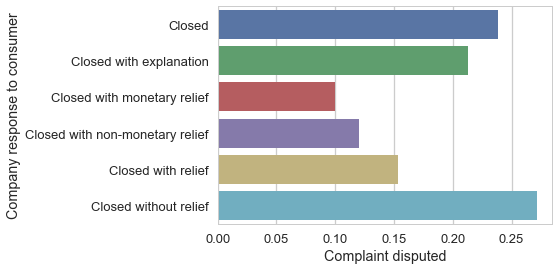

In [15]:

#check how many complaints were disputed for each company response. 
print(df_top_issue_comp.groupby('Company response to consumer')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index())
df_response = df_top_issue_comp.groupby('Company response to consumer')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
df_response.dropna(subset=['Yes'], inplace=True)
sns.barplot(y='Company response to consumer', x='Yes', data = df_response)
plt.xlabel('Complaint disputed')

In [16]:
df['narative_bool'] = pd.isnull(df['Consumer complaint narrative'])

In [17]:
df['narative_int'] = df['narative_bool'].astype(int)

In [18]:
# did narrative or not have an effect on dispute?
df.groupby('Consumer disputed?')['narative_bool'].value_counts(normalize=True).unstack()

narative_bool,False,True
Consumer disputed?,,
No,0.205160,0.794840
Yes,0.243906,0.756094


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

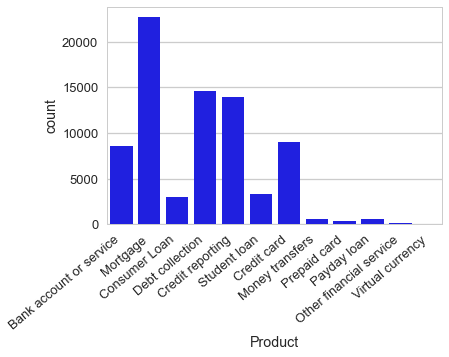

In [19]:
#how many complaints for each financial product?
sns.countplot(df['Product'], color='blue')
plt.xticks(rotation=40, ha="right")

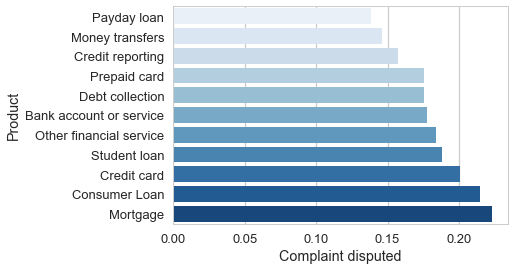

In [20]:
# any product particularly easy to be disputed?
df_product = df.groupby('Product')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()[:-1]
sns.barplot(y='Product', x='Yes', data = df_product.sort_values('Yes'), palette='Blues')
plt.xlabel('Complaint disputed')

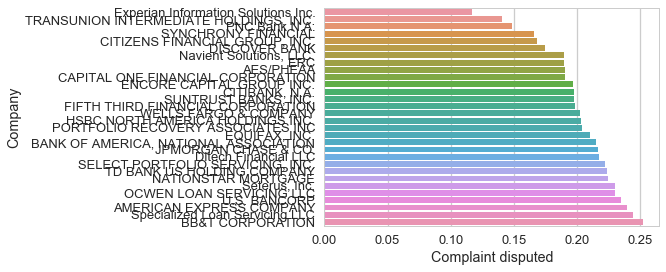

In [21]:
#most appeared companies VS disputed?
df_comp = df_top_issue_comp.groupby('Company')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
sns.barplot(y='Company', x='Yes', data = df_comp.sort_values('Yes'))
plt.xlabel('Complaint disputed')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


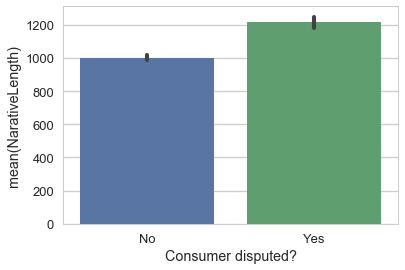

In [31]:
df_narative = df.dropna(axis=0, subset=['Consumer complaint narrative'])
df_narative['NarativeLength'] = [len(nara) for nara in df_narative['Consumer complaint narrative']]
# length of the narrative VS consumer disputed?
sns.barplot(data=df_narative, y='NarativeLength', x='Consumer disputed?')

In [32]:

df_nara_bool = df_top_issue_comp['Consumer complaint narrative'].fillna(0)

df_nara_bool2=[]
for nara in df_nara_bool:
    if nara is not 0:
        df_nara_bool2.append(1)
    else: 
        df_nara_bool2.append(0)
        
df_top_issue_comp['Narrative_bool'] = df_nara_bool2

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [33]:
df_top_issue_comp_short = df_top_issue_comp.drop(['Unnamed: 0', 'Sub-issue', 'Company public response', 'Consumer consent provided?', 'State', 'ZIP code', 'Date sent to company', 'Date received', 'Consumer complaint narrative','Complaint ID', 'Tags'],axis=1)

In [34]:
df_top_issue_comp_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48386 entries, 0 to 104587
Data columns (total 9 columns):
Product                         48386 non-null object
Sub-product                     30844 non-null object
Issue                           48386 non-null object
Company                         48386 non-null object
Submitted via                   48386 non-null object
Company response to consumer    48386 non-null object
Timely response?                48386 non-null object
Consumer disputed?              48386 non-null object
Narrative_bool                  48386 non-null int64
dtypes: int64(1), object(8)
memory usage: 4.9+ MB


In [35]:
df_dummies = pd.get_dummies(data=df_top_issue_comp_short.drop(['Consumer disputed?','Narrative_bool'], axis=1), drop_first=True)

In [36]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48386 entries, 0 to 104587
Columns: 102 entries, Product_Consumer Loan to Timely response?_Yes
dtypes: uint8(102)
memory usage: 6.3 MB


In [37]:
# Identify variables
X = df_dummies.join(df_top_issue_comp_short['Narrative_bool'])
target_map = {'Yes': 1, 'No':0}
y = df_top_issue_comp['Consumer disputed?'].map(target_map)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

print('Raw Training Set Percent Yes: {:.1f}%'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Resampled Training Set Percent Yes: {}%'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

Raw Training Set Percent Yes: 19.8%
Resampled Training Set Percent Yes: 50.0%


In [38]:
#Random forest classifier parameter optimization:

rf = RandomForestClassifier()
param_grid = {"n_estimators": [100, 200, 300],
              "max_features": [75, 100],
              "max_depth": [3, 5, 10]
              }

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.580201809325
Best Parameters: {'max_depth': 5, 'max_features': 75, 'n_estimators': 100}


In [39]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_rus_test)

scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_rus_test, y_rus_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_rus_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_rus_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.58003(+/- 0.02)
Cross Validation Accuracy Scores - Test Set: 0.58997(+/- 0.01)
Confusion matrix on the test data:
[[3495 3024]
 [2430 4089]]
Classification report on the test data:
             precision    recall  f1-score   support

          0       0.59      0.54      0.56      6519
          1       0.57      0.63      0.60      6519

avg / total       0.58      0.58      0.58     13038



In [40]:
len(X)

48386

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


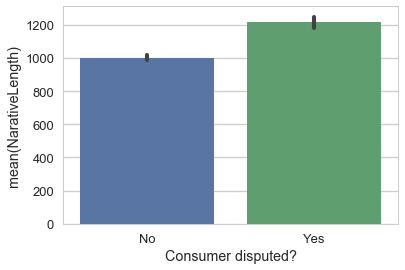

In [41]:
df_narative = df.dropna(axis=0, subset=['Consumer complaint narrative'])
df_narative['NarativeLength'] = [len(nara) for nara in df_narative['Consumer complaint narrative']]
# length of the narrative VS consumer disputed?
sns.barplot(data=df_narative, y='NarativeLength', x='Consumer disputed?')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ba85080>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1245d6e80>], dtype=object)

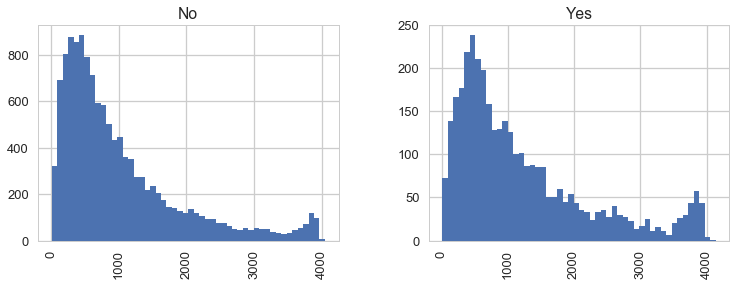

In [42]:
df_narative.hist(column='NarativeLength', by='Consumer disputed?', bins=50,figsize=(12,4))


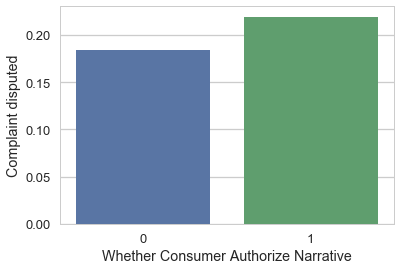

In [43]:
df_narrative_bool = df.groupby('Narrative_bool')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
df_narrative_bool
sns.barplot(x='Narrative_bool', y='Yes', data = df_narrative_bool.sort_values('Yes'))
plt.ylabel('Complaint disputed')
plt.xlabel('Whether Consumer Authorize Narrative')

In [44]:
#nltk.download_shell()

In [45]:
import string
from nltk.corpus import stopwords


def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [46]:
df_narative['Consumer disputed?'].value_counts()

No     12738
Yes     3582
Name: Consumer disputed?, dtype: int64

In [47]:
df_narative['Consumer complaint narrative'].head(1).apply(text_process)

2    [credit, score, ran, 2, times, Spring, Leaf, n...
Name: Consumer complaint narrative, dtype: object

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_narative['Consumer complaint narrative'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

38204


In [50]:
narrative0 = df_narative['Consumer complaint narrative'].head(1)
print(narrative0)
bow0 = bow_transformer.transform([narrative0])

2    I had my credit score ran 2 times by Spring Le...
Name: Consumer complaint narrative, dtype: object


In [51]:
narrative_bow = bow_transformer.transform(df_narative['Consumer complaint narrative'])

In [52]:
print('Shape of Sparse Matrix: ', narrative_bow.shape)
print('Amount of Non-Zero occurences: ', narrative_bow.nnz)

Shape of Sparse Matrix:  (16320, 38204)
Amount of Non-Zero occurences:  1032069


In [53]:
#transform text to TFIDF format

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(narrative_bow)

tfidf0 = tfidf_transformer.transform(bow0)

narrative_tfidf = tfidf_transformer.transform(narrative_bow)
print(narrative_tfidf.shape)

(16320, 38204)


In [54]:
#nbm = MultinomialNB().fit(narrative_tfidf, df_narative['Consumer disputed?'])
#print('predicted:', nbm.predict(tfidf0)[0])
#print('expected:',df_narative['Consumer disputed?'].head(1))

In [55]:
#print('predicted:', nbm.predict(tfidf0)[0])
#print('expected:',df_narative['Consumer disputed?'].head(1))

In [56]:
#random under sampling data and train-test split
from sklearn.model_selection import train_test_split

rus = RandomUnderSampler(random_state=41)
X, y = rus.fit_sample(narrative_tfidf, df_narative['Consumer disputed?'])

msg_train, msg_test, label_train, label_test = train_test_split(X, y , test_size=0.2)

#print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

In [57]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

NameError: name 'MultinomialNB' is not defined

In [ ]:
pipeline.fit(msg_train,label_train)

In [ ]:
predictions = pipeline.predict(msg_test)

In [ ]:

from sklearn.metrics import classification_report
print('Confusion matrix on the data:')
print(confusion_matrix(label_test, predictions))
print('Classification on the data:')
print (classification_report(label_test, predictions))
